# Differentiable fluid simulation

In [24]:
%reset -f

In [25]:
from phi.jax.flow import *      ## Phiflow version 2.2.5
import pylab                    ##for visualizations later on

## Batched simulations

In [26]:
# closed domain
INFLOW_LOCATION = tensor([(12, 4), (13, 6), (14, 5), (16, 5)], batch('inflow_loc'), channel('vector'))
INFLOW = (1./3.) * CenteredGrid(Sphere(x=INFLOW_LOCATION.inflow_loc[:].vector[0], y=INFLOW_LOCATION.inflow_loc[:].vector[1], radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box['x,y', 0:32, 0:40])
BND = extrapolation.ZERO # closed, boundary conditions for velocity grid below

# uncomment this for a slightly different open domain case
#INFLOW_LOCATION = tensor([(11, 6), (12, 4), (14, 5), (16, 5)], batch('inflow_loc'), channel('vector'))
#INFLOW = (1./4.) * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY,x=32, y=40, bounds=Box[0:32, 0:40])
#BND = extrapolation.BOUNDARY # open boundaries

INFLOW.shape

(inflow_locᵇ=4, xˢ=32, yˢ=40)

In [27]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box['x,y', 0:32, 0:40]) # sampled at cell centers
velocity = StaggeredGrid(0, BND, x=32, y=40, bounds=Box['x,y', 0:32, 0:40]) # sampled in staggered form at face centers

@math.jit_compile
def step(smoke, velocity):
    smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW      ## Broadcasting along batch_dim
    buoyancy_force = (smoke * (0, 1)).at(velocity)
    velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
    velocity, _ = fluid.make_incompressible(velocity)
    return smoke, velocity

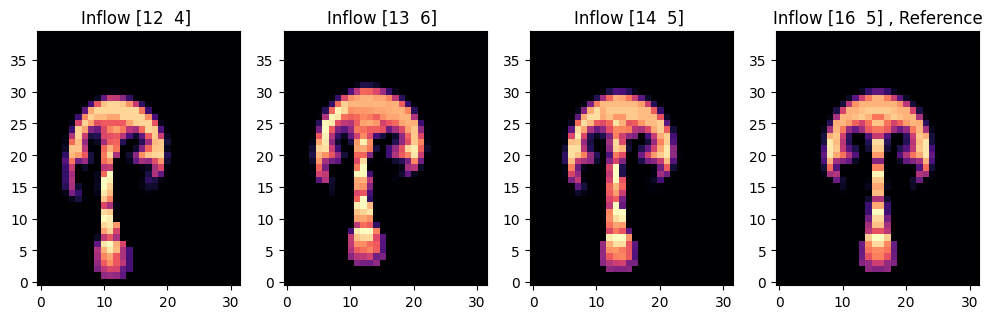

In [28]:
## Run simulations for n=20 steps
for _ in range(20):
    smoke, velocity = step(smoke,velocity)

# store and show final states (before optimization)
smoke_final = smoke
fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
    axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
    axes[i].set_title(f"Inflow { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} " + (", Reference" if i==3 else ""))

pylab.tight_layout()

## Gradients

In [29]:
initial_smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box['x,y', 0:32, 0:40])
initial_velocity = StaggeredGrid(math.zeros(batch(inflow_loc=4)), BND, x=32, y=40, bounds=Box['x,y', 0:32, 0:40])
print("Velocity dimensions: "+format(initial_velocity.shape))

def simulate(smoke: CenteredGrid, velocity: StaggeredGrid):
    for _ in range(20):
        smoke,velocity = step(smoke,velocity)
        loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]) )        ## stop_gradient disables gradients for that var
        #optionally, use smoother loss with diffusion steps - no difference here, but can be useful for more complex cases
        #loss = field.l2_loss(diffuse.explicit(smoke - field.stop_gradient(smoke.inflow_loc[-1]), 1, 1, 10))
    return loss, smoke, velocity

Velocity dimensions: (inflow_locᵇ=4, xˢ=32, yˢ=40, vectorᶜ=x,y)


In [30]:
# @math.jit_compile
# def sim_grad(smoke: CenteredGrid, velocity: StaggeredGrid):
#     grad_fn = field.functional_gradient(simulate, wrt='velocity', get_output=False)
#     return grad_fn(smoke, velocity)

sim_grad = field.functional_gradient(simulate, wrt='velocity', get_output=False)
velocity_grad = sim_grad(initial_smoke, initial_velocity)

print("Some gradient info: " + format(velocity_grad))
print(format(velocity_grad.values.inflow_loc[0].vector[0])) ## one example, location 0, x component, automatically prints size & content range

Some gradient info: StaggeredGrid[(inflow_locᵇ=4, xˢ=32, yˢ=40, vectorᶜ=x,y), size=(x=32, y=40) int64, extrapolation=0]
(xˢ=31, yˢ=40) 3.08e-08 ± 8.5e-01 (-2e+01...1e+01)


<Figure size 1200x500 with 4 Axes>

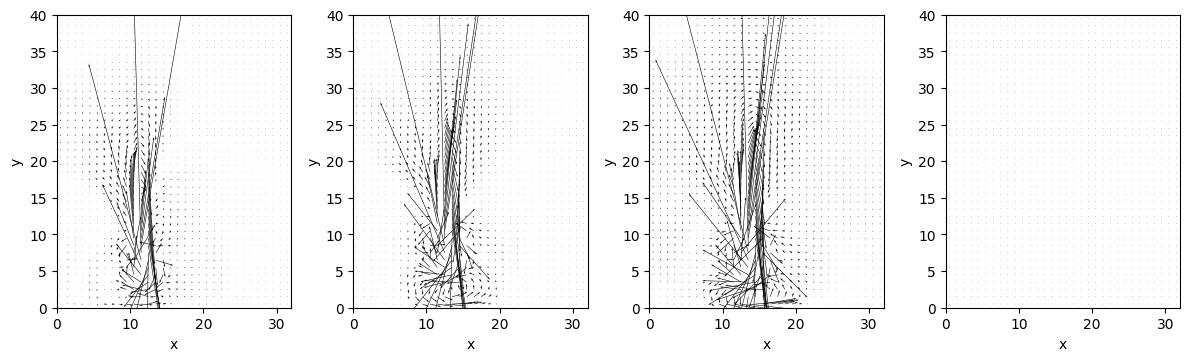

In [31]:
## neat phiflow helper function:
# view(velocity_grad)
vis.plot(velocity_grad)

## Optimisation

In [32]:
sim_grad_wloss = field.functional_gradient(simulate, wrt='velocity', get_output=True) # if we need outputs...

LR = 1e-03

for optim_step in range(80):
    (loss, _smoke, _velocity), velocity_grad = sim_grad_wloss(initial_smoke, initial_velocity)
    initial_velocity = initial_velocity - LR * velocity_grad
    if optim_step<3 or optim_step%10==9: print('Optimization step %d, loss: %f' % (optim_step, np.sum(loss.numpy()) ))

Optimization step 0, loss: 298.286438
Optimization step 1, loss: 291.454376
Optimization step 2, loss: 276.058258
Optimization step 9, loss: 237.968781
Optimization step 19, loss: 203.378525
Optimization step 29, loss: 180.725815
Optimization step 39, loss: 189.574448
Optimization step 49, loss: 174.064819
Optimization step 59, loss: 165.693283
Optimization step 69, loss: 163.894531
Optimization step 79, loss: 161.616745


## Evaluation

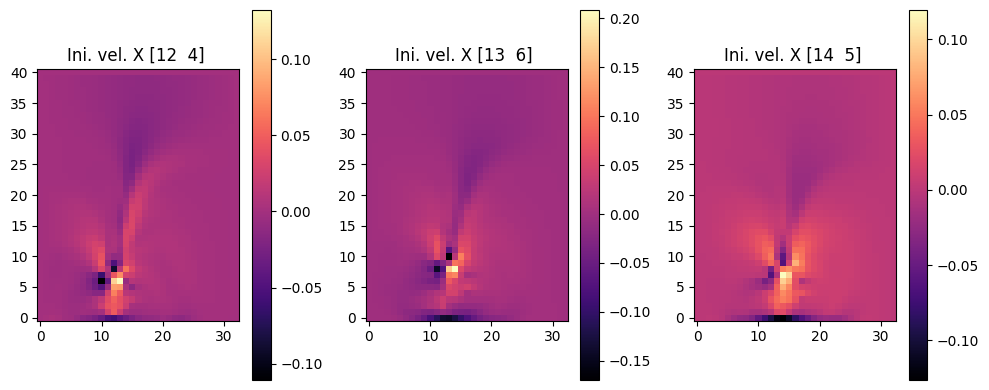

In [33]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
    im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,0], origin='lower', cmap='magma')
    axes[i].set_title(f"Ini. vel. X { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} ")
    pylab.colorbar(im,ax=axes[i])
pylab.tight_layout()

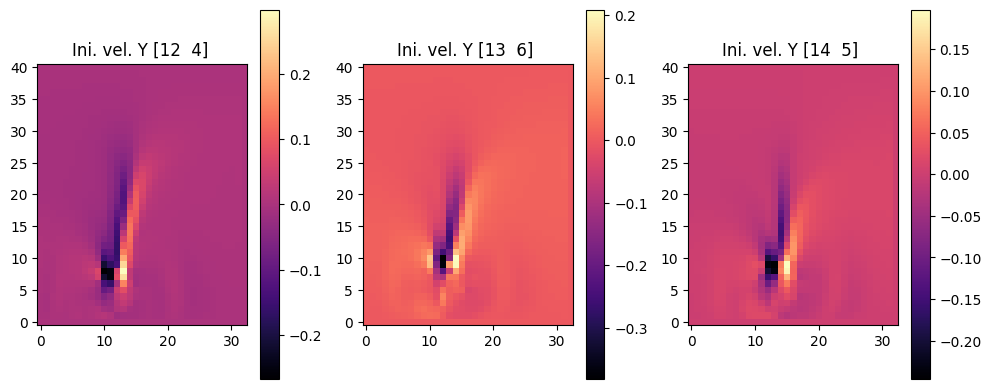

In [34]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
    im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,1], origin='lower', cmap='magma')
    axes[i].set_title(f"Ini. vel. Y { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} ")
    pylab.colorbar(im,ax=axes[i])
    pylab.tight_layout()

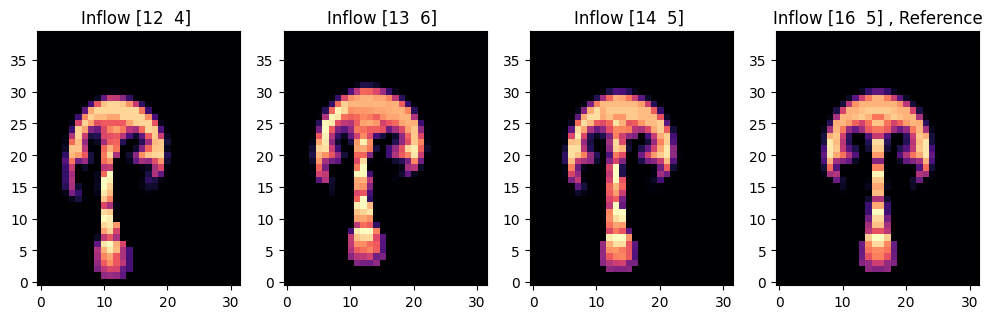

In [38]:
smoke = initial_smoke
velocity = initial_velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
    axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
    axes[i].set_title(f"Inflow { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} " + (", Reference" if i==3 else ""))

pylab.tight_layout()

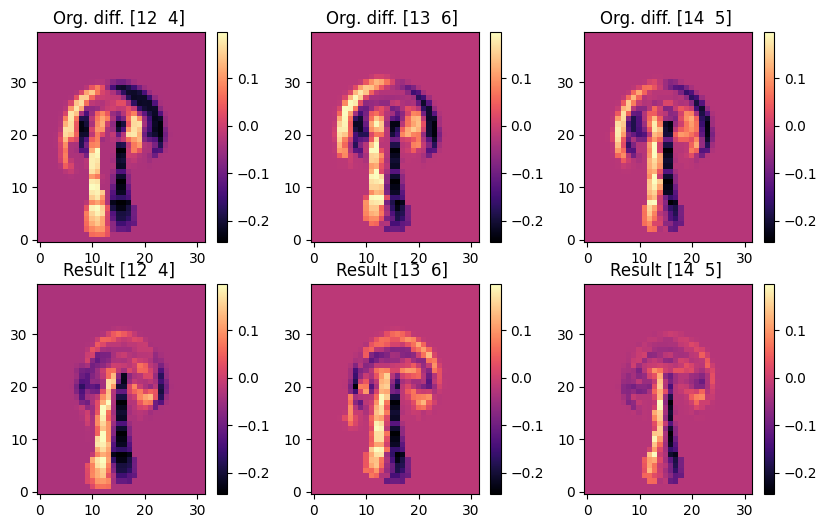

In [39]:
fig, axes = pylab.subplots(2, 3, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
    axes[0,i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
    axes[0,i].set_title(f"Org. diff. { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} ")
    pylab.colorbar(im,ax=axes[0,i])
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
    axes[1,i].imshow(smoke.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
    axes[1,i].set_title(f"Result { INFLOW_LOCATION.numpy('inflow_loc,vector')[i]} ")
    pylab.colorbar(im,ax=axes[1,i])

## Findings
- Jitted `sim_grad` is impracticably slower compared to the unjitted version: whether or not the underlying `simulate` is also jitted or not. This might be due to `fields.functional_gradients`

## Next steps
- Work on the OP-CFE control problem